### Reinforcement learning the active learning policy 



In [28]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.active_learning as al
import src.viz as viz

import importlib as imp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.distributions import Categorical
# import pyro

%matplotlib inline

### Get the data:

Get MNIST formatted from PyTorch.

In [3]:
# Get raw datasets 
train_set = dset.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=False)
test_set = dset.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=len(test_set),shuffle=False)

In [4]:
# Get x/y split for the test set 
train_x, train_y, val_x, val_y = al.get_dataset_split(train_set)
test_x,test_y = al.get_xy_split(test_loader)

### Make the models:

Below we make both the logistic regression and the CNN for experiemnts with RL on active learning policies

In [6]:
# Define the logistic regression model
class logreg(nn.Module):
    """ Logistic regression """
    def __init__(self, classes):
        super(logreg, self).__init__()
        self.classes = classes
        self.w = nn.Linear(28*28,classes)
        
    def forward(self, x):
        x = self.w(x.view(-1,1,28*28))
        return F.log_softmax(x.view(-1,self.classes),dim=1)

# Define the CNN model 
class CNN(nn.Module):
    """ CNN for MNIST """
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)
    

In [10]:
def try_policy(policy, meta_epochs, ept, npoints, batch_size, learning_rate, samp_runs):
    # general policy test 
    try_acc = []
    for i in tqdm(range(samp_runs)):
        model_try = logreg(classes=10)
#         model_try = CNN()
        loss_try = nn.NLLLoss()
        optimizer_try = optim.SGD(model_try.parameters(), lr=learning_rate)
        experi = al.ExperiAL(model_try, train_x, train_y, val_x, val_y, loss_try, optimizer_try)
        _, val_acc = experi.active_learn(policy=policy, epochs_per_train=ept, npoints=npoints, \
                                            batch_size=batch_size, meta_epochs=meta_epochs)
        try_acc.append(val_acc)
    print(f'Active Learning with {policy} policy done!')
    return try_acc

# model = logreg(classes=10)
# loss_func = nn.NLLLoss()
# optimizer = optim.SGD(model.parameters(), lr=.01)
# experiment = al.ExperiAL(model, train_x, train_y, val_x, val_y, loss_func, optimizer)
# experiment.active_learn(policy='boundary', meta_epochs=5, epochs_per_train=5, npoints=20, batch_size=10)

# accs = [random_acc,boundary_acc,entropy_acc, confidence_acc,uniform_acc]
# sample_acc = [a[-1][-1] for a in accs]
# labs = ['Random','Boundary','Max Entropy', 'Least Confidence','Uniform']
# nice_labs = [lab+f' {a}' for lab,a in zip(labs,sample_acc)]
# viz.plot_results(meta_epochs,accs,nice_labs)

### RL approach - Policy Gradients (PG)

* Source: http://karpathy.github.io/2016/05/31/rl/

Here I will try the PG appraoch to this problem.

##### Ideas:

* actions are choosing the policy by which we choose the next point. 

* so is the state the performance of the model or the model itself or the parameters?? 

* OR IS THE STATE THE SET OF UNLABELED POINTS?!?!

* State is the set of all training points 

* NO state should be the marginals $p(\mathbf{y}|x_i)$ for real!!!

* could use grad of accuracy to approx reward function. steeper the gradient higher the reward.

In [29]:
# Make the RL agent to interact with the environment 
class AgentRL(nn.Module):
    def __init__(self, inpt_dim, hidden_dim, num_policies):
        super(AgentRL, self).__init__()
        self.num_policies = num_policies
        self.inner_layer = nn.Linear(inpt_dim, hidden_dim)
        self.outer_layer = nn.Linear(hidden_dim, num_policies)
        self.rewards = []
        self.saved_log_probs = []
        
    def forward(self, x):
        x = F.relu(self.inner_layer(x))
        x = self.outer_layer(x)
        return F.softmax(x, dim=1)

def select_action(rl_agent, state):
#     state = torch.from_numpy(state).float().unsqueeze(0)
    if use_cuda:
        probs = rl_agent(Variable(state.cuda()))
    else:
        probs = rl_agent(Variable(state))
    m = Categorical(probs)
    action = m.sample()
    rl_agent.saved_log_probs.append(m.log_prob(action))
    return action.data[0]

arl = AgentRL(4, 128, 5)

### One RL approach (DQN):

This is currently not working but could be good to try after policy gradients 

1 epoch acc 0.8274
OrderedDict([('w.weight', 
-3.0095e-02 -4.3774e-03 -1.1128e-02  ...  -1.8133e-02  1.5993e-02 -6.1285e-03
-1.1412e-03  1.1096e-02 -3.4081e-02  ...  -1.3653e-02 -2.1021e-02  6.1761e-03
-2.7035e-02  3.1876e-02  2.7182e-02  ...  -2.4003e-02 -3.5375e-02  3.4048e-02
                ...                   ⋱                   ...                
 2.9983e-03  1.9402e-03  2.5775e-02  ...   2.1912e-02 -3.3439e-02  1.1415e-02
-2.7456e-02 -3.3077e-04 -2.6443e-02  ...  -2.8893e-02  2.0001e-02  9.3709e-03
-9.9710e-03  1.2108e-02 -3.2164e-02  ...   2.9064e-02 -1.2496e-02 -1.7155e-02
[torch.FloatTensor of size 10x784]
), ('w.bias', 
1.00000e-02 *
 -6.5094
  9.2180
 -3.3772
  0.2998
  1.2790
  4.2864
  0.2122
  4.4110
 -4.8635
 -2.7203
[torch.FloatTensor of size 10]
)])
OrderedDict([('w.weight', 
-0.0301 -0.0044 -0.0111  ...  -0.0181  0.0160 -0.0061
-0.0011  0.0111 -0.0341  ...  -0.0137 -0.0210  0.0062
-0.0270  0.0319  0.0272  ...  -0.0240 -0.0354  0.0340
          ...             ⋱   

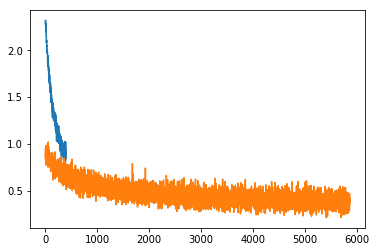

In [9]:
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

model = logreg(classes=10)
loss_func = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=.01)
experiment = al.ExperiAL(model, train_x, train_y, val_x, val_y, loss_func, optimizer)
it,ac = experiment._train(train_x, train_y, epochs=1, batch_size=128)

plt.plot(it,ac)
sd = model.state_dict()
print('1 epoch acc',al.accuracy(model,val_x,val_y))
print(sd)
it,ac = experiment._train(train_x, train_y, epochs=15, batch_size=128)
plt.plot(it,ac)
sd2 = model.state_dict()
print(sd2)
print('20 epoch acc',al.accuracy(model,val_x,val_y))
print(sd)
model.load_state_dict(sd)
model.state_dict()
print('should be 5 epoch acc',al.accuracy(model,val_x,val_y))


In [11]:
preds = [5,5,6,7,8,4,3,2]
num_points, sampler = len(preds), np.array(range(len(preds)))
# output = []
for i in range(num_points):
    print(np.random.choice(preds, size=num_points, replace=False))

[2 8 6 5 5 3 4 7]
[2 3 5 4 7 6 8 5]
[5 8 5 2 7 6 4 3]
[4 5 2 6 7 8 3 5]
[5 6 2 5 4 8 3 7]
[6 5 4 2 5 7 3 8]
[8 5 2 4 7 3 5 6]
[5 3 5 7 4 8 2 6]
